In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
CHANNELS = 3
EPOCHS = 35

In [4]:
from google.colab import drive
import tensorflow as tf

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Specify the path to your dataset
dataset_path = '/content/drive/MyDrive/project images'

# Define your image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Create the image dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Mounted at /content/drive
Found 760 files belonging to 38 classes.


In [5]:
class_names = dataset.class_names
class_names

['Asian koel',
 'Black rumped flameback woodpecker',
 'Black-Hooded Oriole',
 'Brahminy Kite',
 'Brown-headed Barbet',
 'Cattle egret',
 'Cockoo',
 'Common tailorbird',
 'Cotton Pygmy Goose',
 'Crow',
 'Drongo',
 'Duck',
 'Great Hornbill',
 'Great eared nightjar',
 'Greater Flamingoes',
 'Hen',
 'Indian grey hornbill',
 'Indian pitta',
 'Jungle Babbler',
 'Knob-billed duck',
 "Loten's sunbird",
 'Love Birds',
 'Myna',
 'Oriental Magpie Robin',
 'Owl',
 'Purple Heron',
 'Rain Quail',
 'Red whiskered bulbul',
 'Rose-ringed Parakeet',
 'Rufous treepie',
 'Srilankan frogmouth',
 'White-breasted-water hen',
 'cormorant',
 'coucal',
 'gull',
 'kingfisher',
 'peacock',
 'pigeon']

In [6]:
len(dataset)

24

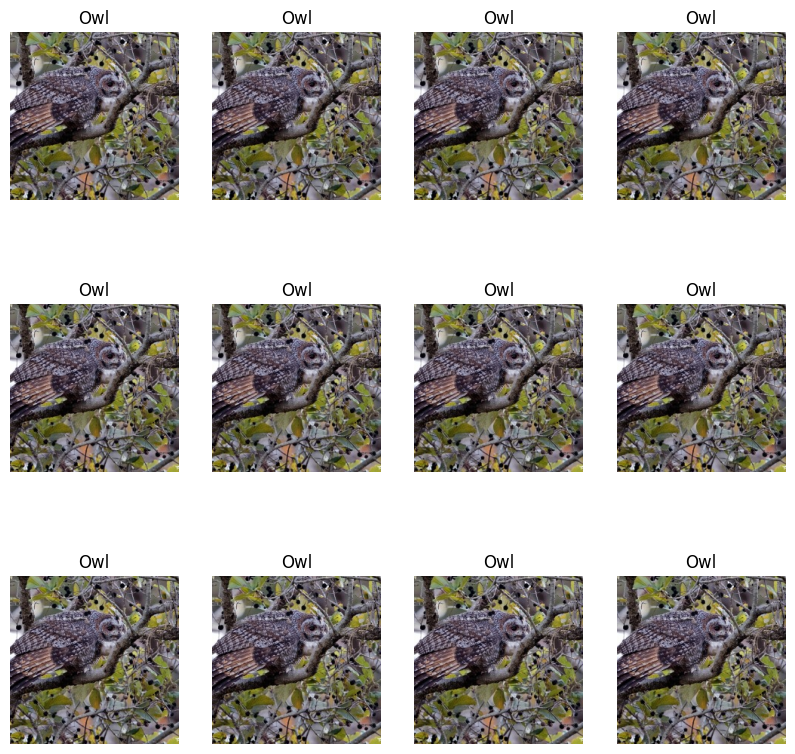

In [7]:

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [ ]:
len(dataset)

24

In [ ]:
train_size = 0.8
len(dataset)*train_size

19.200000000000003

In [ ]:
train_ds = dataset.take(80)
len(train_ds)

24

In [ ]:
test_ds = dataset.skip(80)
len(test_ds)

0

In [ ]:
val_size = 0.1
len(dataset)*val_size

2.4000000000000004

In [ ]:
val_ds = test_ds.take(10)
len(val_ds)

0

In [ ]:
test_ds = test_ds.skip(10)
len(test_ds)

0

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)
    if shuffle:
      ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

19

In [ ]:
len(val_ds)

2

In [ ]:
len(test_ds)

3

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.image.resize_with_pad(x, IMAGE_SIZE[0], IMAGE_SIZE[1])),
    layers.Lambda(lambda x: x * (1./255.0)),  # Rescale
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (1, IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)
n_classes = 38

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(38, activation='softmax'),
])

# No need to explicitly build the model in Colab

# Display model summary
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (1, 222, 222, 32)         896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (1, 111, 111, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (1, 109, 109, 64)         18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (1, 54, 54, 64)           0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (1, 52, 52, 64)          

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Assuming train_ds has elements in the form (images, labels)
train_labels = [label for _, label in train_ds]
val_labels = [label for _, label in val_ds]

# Flatten nested labels
train_labels_flat = [item for sublist in train_labels for item in sublist]
val_labels_flat = [item for sublist in val_labels for item in sublist]

In [ ]:
train_labels_one_hot = to_categorical(train_labels_flat, num_classes=n_classes)
val_labels_one_hot = to_categorical(val_labels_flat, num_classes=n_classes)

In [ ]:
print(f"Train labels shape: {train_labels_one_hot.shape}")
print(f"Validation labels shape: {val_labels_one_hot.shape}")

Train labels shape: (608, 38)
Validation labels shape: (56, 38)


In [ ]:
model.output_shape

(1, 38)

In [ ]:
print(f"Type of train_labels: {type(train_labels)}")
print(f"Type of val_labels: {type(val_labels)}")

Type of train_labels: <class 'list'>
Type of val_labels: <class 'list'>


In [ ]:
train_labels_one_hot.shape
val_labels_one_hot.shape

(56, 38)

In [ ]:
model.output_shape == train_labels_one_hot.shape
model.output_shape == val_labels_one_hot.shape

False

In [ ]:
# Remove the to_categorical calls
train_labels_one_hot = train_labels_flat
val_labels_one_hot = val_labels_flat

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [ ]:
# Remove the to_categorical calls
train_labels_one_hot = train_labels_flat
val_labels_one_hot = val_labels_flat

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=35,
)

Epoch 1/35
19/19 [==============================] - 55s 3s/step - loss: 1.2602 - accuracy: 0.6283 - val_loss: 1.7925 - val_accuracy: 0.6250
Epoch 2/35
19/19 [==============================] - 52s 3s/step - loss: 0.9527 - accuracy: 0.7237 - val_loss: 2.2139 - val_accuracy: 0.6071
Epoch 3/35
19/19 [==============================] - 52s 3s/step - loss: 0.8532 - accuracy: 0.7484 - val_loss: 2.0199 - val_accuracy: 0.6607
Epoch 4/35
19/19 [==============================] - 54s 3s/step - loss: 0.7796 - accuracy: 0.7829 - val_loss: 2.1944 - val_accuracy: 0.6429
Epoch 5/35
19/19 [==============================] - 54s 3s/step - loss: 0.8161 - accuracy: 0.7632 - val_loss: 3.6657 - val_accuracy: 0.5893
Epoch 6/35
19/19 [==============================] - 52s 3s/step - loss: 0.7810 - accuracy: 0.7796 - val_loss: 2.4759 - val_accuracy: 0.7143
Epoch 7/35
19/19 [==============================] - 54s 3s/step - loss: 0.9175 - accuracy: 0.7418 - val_loss: 1.6024 - val_accuracy: 0.6429
Epoch 8/35
19/19 [==

In [ ]:
score = model.evaluate(test_ds)
scores = score

print(scores)

3/3 [==============================] - 5s 712ms/step - loss: 2.3603 - accuracy: 0.9583
[2.360306978225708, 0.9583333134651184]


In [ ]:
history.params

{'verbose': 1, 'epochs': 35, 'steps': 19}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

35

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.2602498531341553,
 0.9526942372322083,
 0.8532000184059143,
 0.7795849442481995,
 0.8160727024078369]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

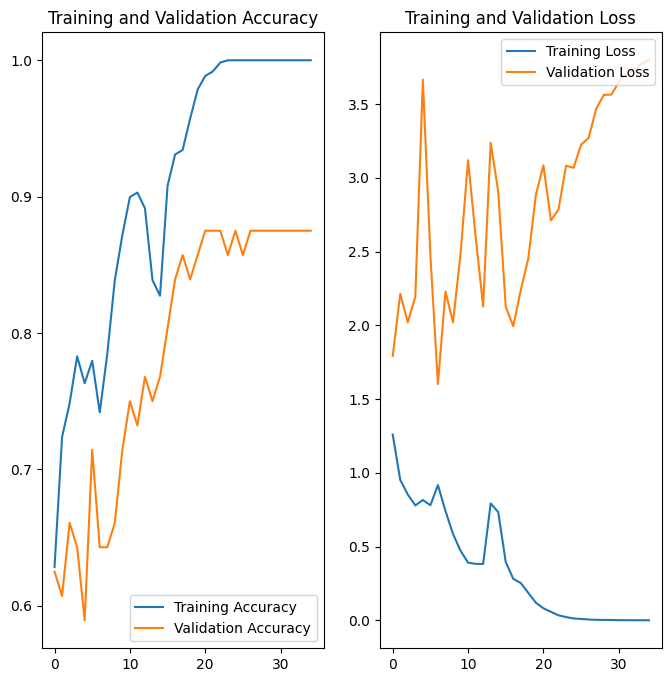

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Greater Flamingoes
1/1 [==============================] - 1s 1s/step
predicted label: Greater Flamingoes
first image to predict
actual label: gull
1/1 [==============================] - 2s 2s/step
predicted label: gull


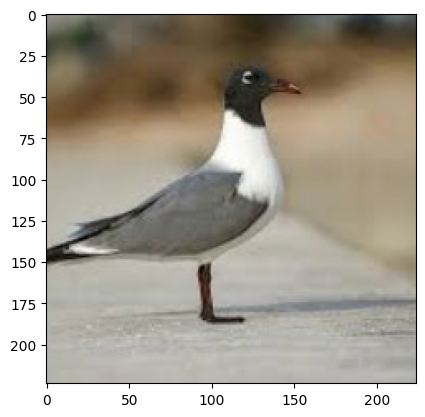

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(2):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    # Convert the image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Expand the dimensions to match the model's expected input shape
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model.predict(img_array)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions[0])

    # Get the class name corresponding to the predicted index
    predicted_class = class_names[predicted_class_index]

    # Get the confidence (probability) for the predicted class
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 39ms/step


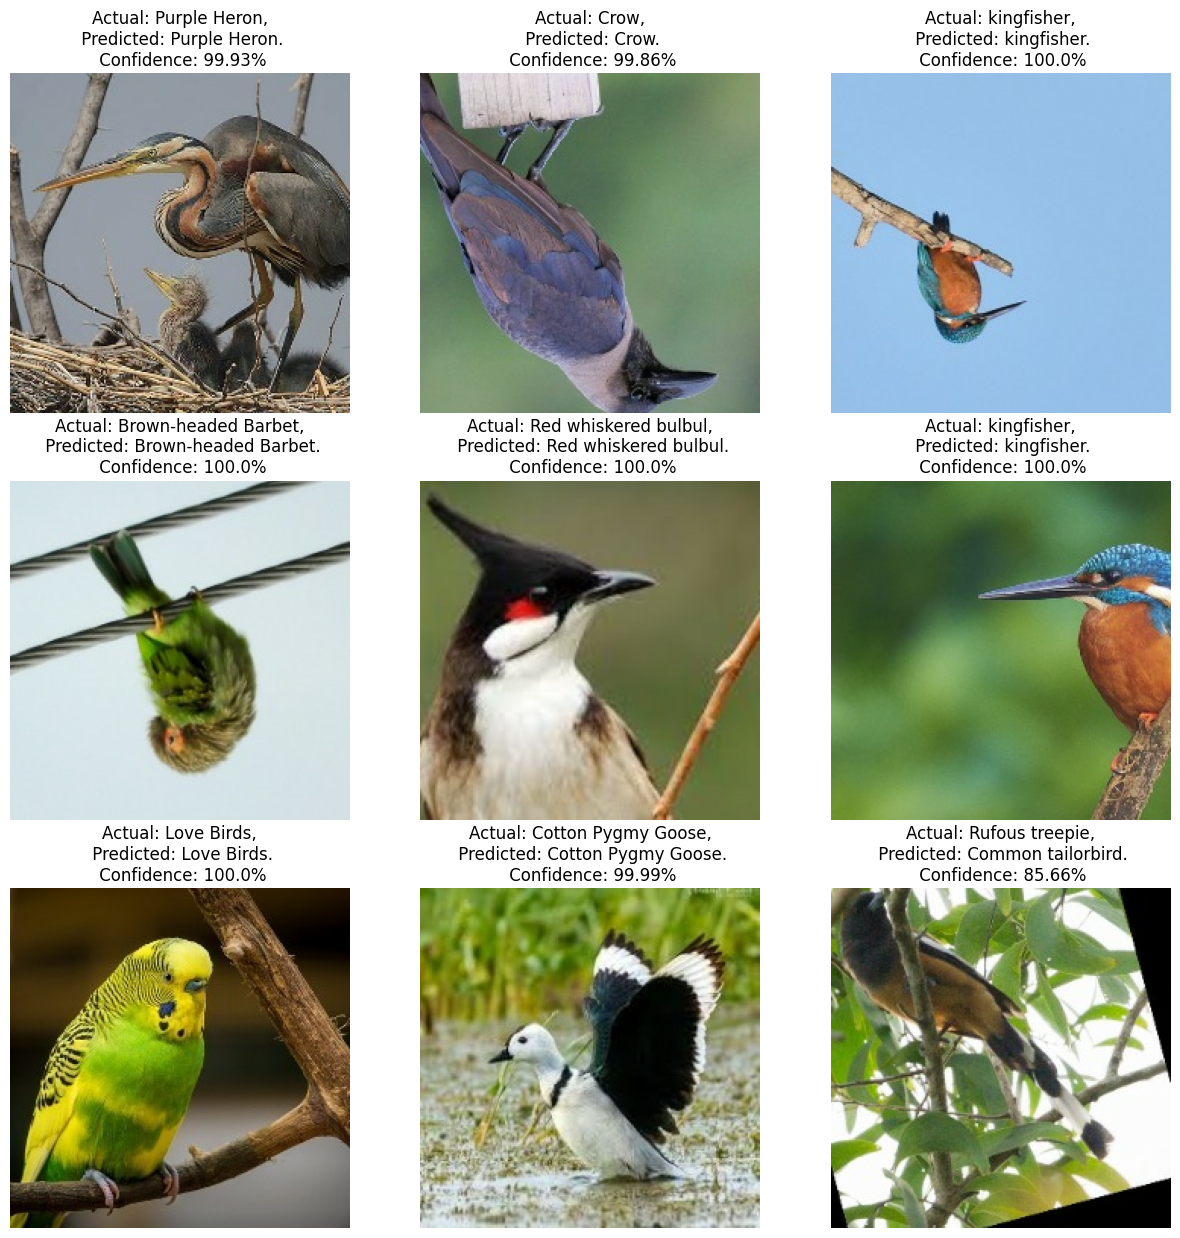

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
import os

# Create the 'models' directory if it doesn't exist
models_dir = '/content/models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# List existing models in the 'models' directory
existing_models = [f for f in os.listdir(models_dir) if f.endswith('.h5')]

# Find the highest model version and increment it
model_version = max([int(model[:-3]) for model in existing_models] + [0]) + 1

# Save the model with the new version
model.save(f"{models_dir}/model_{model_version}.h5")